In [1]:
# Imports
import numpy as np
from scipy.special import j0, j1, jn_zeros
from scipy.io import readsav
import matplotlib.pyplot as plt
from time import time as tttt
from scipy.ndimage import map_coordinates as mp
from tqdm import tqdm
import sys

# Set numpy print_options
np.set_printoptions(precision=3, threshold=sys.maxsize)

In [2]:
# Define some important constants
M = 2 # Number of order of Bessel functions
L = 7 # Number of harmonics
RADII = np.linspace(0, 1, 100) # Radial coordinates
ANGLES = np.linspace(0, 2*np.pi, 100) # Angular coordinates

In [3]:
def read_struct(shot):
    # Read the structure from the file
    filename = f'../Data/rfx_{shot}_2.sav'
    struct = readsav(filename)
    return struct

In [4]:
# Function to calculate the Bessel zeros and functions
def get_bessel():
  zeros = np.array([jn_zeros(m, L) for m in range(M)])
  # Adds a zero to the zeros of the bessel function Jml
  zero = np.zeros(1)
  # Concatenate the zeros[1] minus the last element to the array zero
  zero = np.concatenate((zero, zeros[1, :-1]))
  zeros[1] = zero
  print(zeros)
  J0_xr = np.array([j0(zeros[0]*r) for r in RADII])
  J1_xr = np.array([j1(zeros[1]*r) for r in RADII])
  return J0_xr, J1_xr

In [5]:
# Functions to reconstruct the emissivities, the first one uses a for cicle on 
# the time variable, the second does not

def reconstruct_emissivity(shot):
  # Load the data
  st = read_struct(shot).st # A standard name for the .sav files should be used
  radius = st['bright'][0]['radius'][0] # The machine radius

  # Get the data
  coeff = st['emiss'][0]['coeff'][0] # The coefficients are 21 for each time instant
  time = st['emiss'][0]['time'][0] # The time instants
  J0_xr, J1_xr = get_bessel()
  start = tttt()
  g_r_t = np.zeros((len(time), len(RADII), len(ANGLES)))
  for ind in range(len(time)):
    a0Cl, a1cl, a1sl = np.split(coeff[ind], 3)
    dot_0c = np.dot(J0_xr, a0Cl)
    dot_1c = np.dot(J1_xr, a1cl)
    dot_1s = np.dot(J1_xr, a1sl)
    # for i_ang, angle in enumerate(ANGLES):
    #   g_r_t[ind, :, i_ang] = dot_0c + dot_1c*np.cos(angle) + dot_1s*np.sin(angle)
    g_r_t[ind] = dot_0c[:,None] + dot_1c[:,None]*np.cos(ANGLES) + dot_1s[:,None]*np.sin(ANGLES)
  print(f'Time taken for: {tttt() - start} seconds')
  return g_r_t/radius

def reconstruct_emissivity_no_for(shot):
  # Load the data
  st = read_struct(shot).st # A standard name for the .sav files should be used
  radius = st['bright'][0]['radius'][0] # The machine radius

  # Get the data
  coeff = st['emiss'][0]['coeff'][0] # The coefficients are 21 for each time instant
  time = st['emiss'][0]['time'][0] # The time instants

  J0_xr, J1_xr = get_bessel()
  start = tttt()
  g_r_t = np.zeros((len(time), len(RADII), len(ANGLES)))

  # Get the coefficients
  a0cl, a1cl, a1sl = np.split(coeff, 3, axis=1)

  # Compute the dot products using matrix multiplication
  dot_0c = np.dot(J0_xr, a0cl.T).T
  dot_1c = np.dot(J1_xr, a1cl.T).T
  dot_1s = np.dot(J1_xr, a1sl.T).T

  # Compute the emissivity profile using broadcasting
  g_r_t = dot_0c[:, :, None] + dot_1c[:, :, None] * np.cos(ANGLES) + dot_1s[:, :, None] * np.sin(ANGLES)
  print(f'Time taken: {tttt() - start} seconds')
  return g_r_t/radius

In [6]:
# This function is used to plot the emissivity profile, it takes the emissivity 
# profile computed in polar coordinates and maps it to cartesian coordinates
# by simply connecting the sides of the square matrix in polar coordinates

def plot_emissivity(emissivity):
  # Convert polar coordinates to Cartesian coordinates
  x = np.outer(RADII, np.cos(ANGLES))
  y = np.outer(RADII, np.sin(ANGLES))

  # Reshape the emissivity profile matrix to match the Cartesian coordinates
  emissivity_profile_cartesian = np.reshape(emissivity, (len(RADII), len(ANGLES)))

  # Plot the emissivity profile in Cartesian coordinates
  plt.pcolormesh(x, -y, emissivity_profile_cartesian)
  plt.colorbar()
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Emissivity Profile (Cartesian Coordinates)')
  plt.show()

# This function simply plots the matrix in polar coordinates as is
def plot_emissivity_polar(emissivity):
  plt.pcolormesh(emissivity)
  plt.colorbar()
  plt.xlabel('Angle')
  plt.ylabel('Radius')
  plt.title('Emissivity Profile (Polar Coordinates)')
  plt.show()

In [7]:
# The following function completely remaps the emissivity profile to Cartesian
# coordinates using the map_coordinates function from scipy.ndimage (interpolation)

import numpy as np

# Auxiliary function to map polar data to a cartesian plane
def polar_to_cart(polar_data, theta_step, range_step, x, y, order=1):

    from scipy.ndimage import map_coordinates as mp

    # "x" and "y" are numpy arrays with the desired cartesian coordinates
    # we make a meshgrid with them
    X, Y = np.meshgrid(x, y)

    # Now that we have the X and Y coordinates of each point in the output plane
    # we can calculate their corresponding theta and range
    Tc = np.degrees(np.arctan2(Y, X)).ravel()
    Rc = (np.sqrt(X**2 + Y**2)).ravel()

    # Negative angles are corrected
    Tc[Tc < 0] = 360 + Tc[Tc < 0]

    # Using the known theta and range steps, the coordinates are mapped to
    # those of the data grid
    Tc = Tc / theta_step
    Rc = Rc / range_step

    # An array of polar coordinates is created stacking the previous arrays
    coords = np.vstack((Tc, Rc))

    # To avoid holes in the 360º - 0º boundary, the last column of the data
    # copied in the begining
    polar_data = np.vstack((polar_data, polar_data[-1,:]))

    # The data is mapped to the new coordinates
    # Values outside range are substituted with nans
    cart_data = mp(polar_data, coords, order=order, mode='constant', cval=-5)

    # The data is reshaped and returned
    return(cart_data.reshape(len(y), len(x)))

In [40]:
def main():
  # Load the data
  shot = 30929
  data = read_struct(shot)
  emissivity_profile = reconstruct_emissivity(shot)

  # Select the time index to plot
  t_ind = 0

  # Select the st_e structure from the data
  dst_e = data.st_e

  # We create the x and y axes of the output cartesian data
  x = dst_e.X_EMISS[0] - dst_e.MAJR[0]
  y = dst_e.Y_EMISS[0]

  # We call the mapping function assuming 3.6 degree of theta step and r/100
  # of range step. 
  th_step = 3.6
  r_step = data['st']['bright'][0]['radius'][0]/100
  cart_data = polar_to_cart(emissivity_profile[t_ind].T, th_step, r_step, x, y, order=1)

  # We plot the data in cartesian coordinates
  fig, ax = plt.subplots(1,2, figsize=(10,5))
  im0 = ax[0].imshow(dst_e.EMISS[0][t_ind], origin='lower')
  ax[0].set_title('Original')
  fig.colorbar(im0, ax=ax[0], shrink=0.6)
  im1 = ax[1].imshow(cart_data, origin='lower')
  ax[1].set_title('Remapped')
  fig.colorbar(im1, ax=ax[1], shrink=0.6)
  plt.show()

  # We plot the difference between the two profiles at the diameter
  fig1, ax1 = plt.subplots(1,2, figsize=(10,5))
  im3 = ax1[0].imshow(dst_e.EMISS[0][t_ind] - cart_data, origin='lower')
  ax1[0].set_title('Difference of emissivities')
  fig1.colorbar(im3, ax=ax1[0], shrink=0.6)
  ax1[1].plot(dst_e.EMISS[0][t_ind,55,:] - cart_data[55, :])
  ax1[1].plot(dst_e.EMISS[0][t_ind,:,55] - cart_data[:, 55])
  ax1[1].set_xlim(10, 99)
  ax1[1].set_title('Difference at the diameters')

  plt.show()

  # print(dst_e.EMISS[0][t_ind][np.where(dst_e.EMISS[0][t_ind] <= 0)])


[[ 2.405  5.52   8.654 11.792 14.931 18.071 21.212]
 [ 0.     3.832  7.016 10.173 13.324 16.471 19.616]]
Time taken for: 0.3512568473815918 seconds


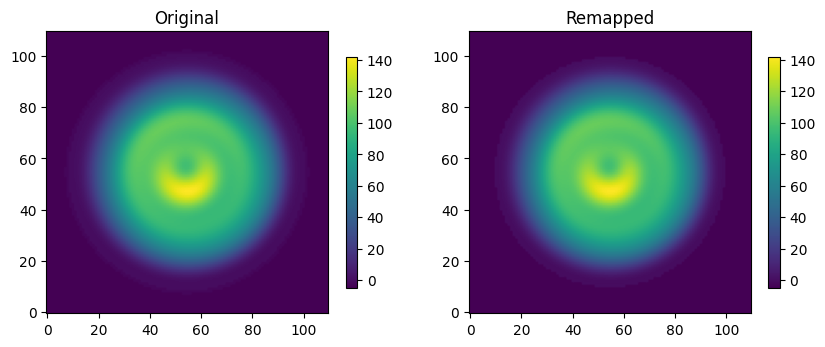

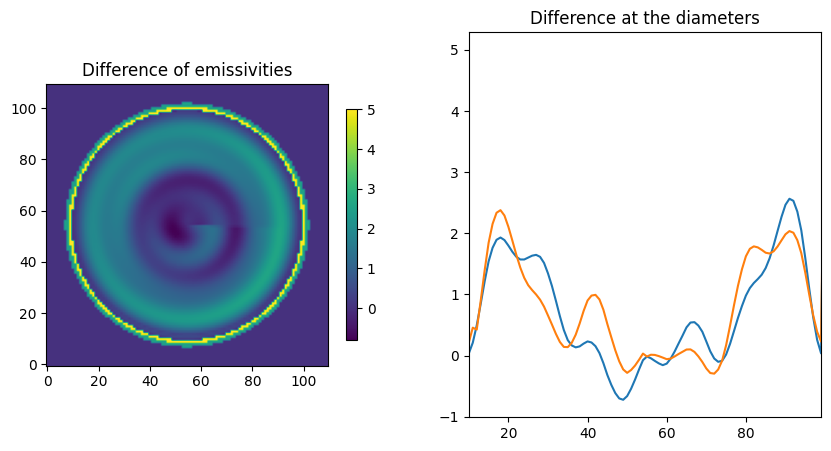

In [41]:
main()